In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
data_dir = '...'
# function to create data loaders
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.RandomRotation(30), # Augement
                                           transforms.RandomResizedCrop((224, 224)),# Augement
                                           transforms.Resize((224, 224)),# Suitable for Model input
                                           transforms.ToTensor(), # convert to tensor
                                       ])
    test_transforms = transforms.Compose([transforms.Resize((224, 224)),# Suitable for Model input
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data) # to calculate validation set size
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler # to sample without replacement
    train_idx, test_idx = indices[split:], indices[:split] # divide into train and test
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(len(trainloader.dataset.classes))

44


In [3]:
device = torch.device("cuda") # use GPU on google Colab
model = models.resnet50(pretrained=True) # pre-trained resnet50 to extract features
# print(model)

In [4]:
# freeze CV layers
for param in model.parameters():
    param.requires_grad = False

# define FC layers
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 44),
                                 nn.LogSoftmax(dim=1))# to calculate probabilities
criterion = nn.NLLLoss() # suitable for calculating probabilites
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device);

In [5]:
epochs = 3
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'model.pth')

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/3.. Train loss: 3.783.. Test loss: 3.008.. Test accuracy: 0.247
Epoch 1/3.. Train loss: 2.837.. Test loss: 2.474.. Test accuracy: 0.337
Epoch 1/3.. Train loss: 2.571.. Test loss: 2.318.. Test accuracy: 0.343
Epoch 1/3.. Train loss: 2.393.. Test loss: 2.191.. Test accuracy: 0.380
Epoch 2/3.. Train loss: 2.290.. Test loss: 2.194.. Test accuracy: 0.349
Epoch 2/3.. Train loss: 2.072.. Test loss: 2.098.. Test accuracy: 0.376
Epoch 2/3.. Train loss: 2.001.. Test loss: 2.031.. Test accuracy: 0.412
Epoch 2/3.. Train loss: 1.991.. Test loss: 1.997.. Test accuracy: 0.399
Epoch 2/3.. Train loss: 2.069.. Test loss: 1.989.. Test accuracy: 0.403
Epoch 3/3.. Train loss: 1.966.. Test loss: 2.046.. Test accuracy: 0.384
Epoch 3/3.. Train loss: 1.893.. Test loss: 1.966.. Test accuracy: 0.407
Epoch 3/3.. Train loss: 1.832.. Test loss: 1.981.. Test accuracy: 0.389
Epoch 3/3.. Train loss: 1.863.. Test loss: 1.981.. Test accuracy: 0.405
Epoch 3/3.. Train loss: 1.854.. Test loss: 1.945.. Test accuracy

In [6]:
from matplotlib import pyplot as plt

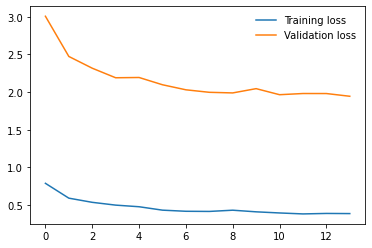

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()